In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
np.random.seed(42)
df = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/train.csv")

In [5]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [6]:
df = df.drop("qid", axis=1)
df.head(10)

,question_text,target
0,How did Quebec nationalists see their province...,0
1,"Do you have an adopted dog, how would you enco...",0
2,Why does velocity affect time? Does velocity a...,0
3,How did Otto von Guericke used the Magdeburg h...,0
4,Can I convert montra helicon D to a mountain b...,0
5,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,Why does Quora automatically ban conservative ...,0
7,Is it crazy if I wash or wipe my groceries off...,0
8,"Is there such a thing as dressing moderately, ...",0
9,Is it just me or have you ever been in this ph...,0


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
x = df["question_text"]
y = df["target"]

vectorizer = TfidfVectorizer(
    max_features = 10000,
    ngram_range = (1,2),
    stop_words = 'english'
)

x_tfidf = vectorizer.fit_transform(x)

df_balanced = pd.DataFrame({'text': x, 'target': y})

class_0 = df_balanced[df_balanced['target'] == 0]
class_1 = df_balanced[df_balanced['target'] == 1]

# Find minority class size
min_size = min(len(class_0), len(class_1))

# Downsample majority class
class_0_downsampled = class_0.sample(min_size, random_state=42)
class_1_downsampled = class_1.sample(min_size, random_state=42)

# Combine and shuffle
df_resampled = pd.concat([class_0_downsampled, class_1_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Final feature and target after resampling
x_resampled = vectorizer.transform(df_resampled['text'])
y_resampled = df_resampled['target']

In [9]:
xtrain, xval, ytrain, yval = train_test_split(x_resampled, y_resampled, random_state=42, stratify=y_resampled)
xtest = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/test.csv')
xtesti = xtest['question_text']

In [10]:
from sklearn.utils.class_weight import compute_class_weight

In [11]:
import matplotlib.pyplot as plt

{0: 1.000008249872127, 1: 0.9999917502639916}


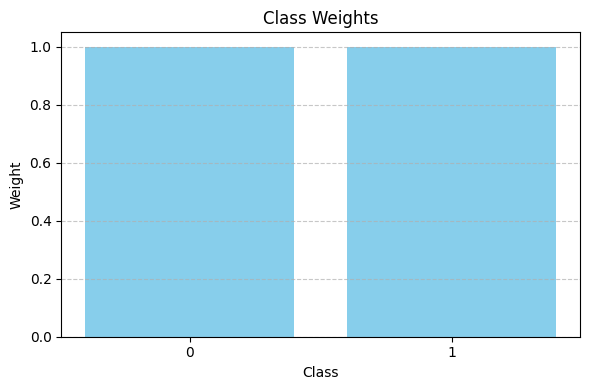

In [12]:
classw = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(ytrain),
    y=ytrain
)
classwdict = dict(enumerate(classw))
print(classwdict)
plt.figure(figsize=(6,4))
plt.bar(classwdict.keys(), classwdict.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Weight')
plt.title('Class Weights')
plt.xticks(list(classwdict.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [13]:
import xgboost as xgb

In [14]:
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

In [15]:
model.fit(xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

ypred=model.predict(xval)
ypredproba = model.predict_proba(xval)[:,1]

accuracy_score(yval, ypred)

0.833881945303799

In [17]:
test_tfidf = vectorizer.fit_transform(xtesti)

def submit():
    submission = xtest[['qid']].copy()  # Use original DataFrame here
    prediction = model.predict_proba(test_tfidf)[:, 1]
    pred = (prediction > 0.5).astype(int)
    submission['prediction'] = pred
    submission.to_csv('submission.csv', index=False)
    return submission


submit()

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0
